In [1]:
!pip install keras-tuner 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import kerastuner 
import matplotlib.pyplot as plt
import numpy as np


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

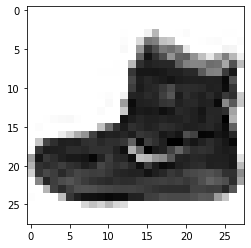

In [5]:
plt.imshow(x_train[0],cmap='binary')

In [52]:
def create_model(hp):

  num_hidden_layers = 1
  num_units = 8
  dropout_rate = 0.1
  learning_rate = 0.01

  if hp:
    num_hidden_layers = hp.Choice('num_hidden_layers', values=[1,2,3])
    num_units = hp.Choice('num_units', values=[8,16,32])
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5)
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01)

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
  model.add(tf.keras.layers.Lambda(lambda x: x/255.))

  for _ in range(0, num_hidden_layers):
    model.add(tf.keras.layers.Dense(num_units, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))

  model.add(tf.keras.layers.Dense(10, activation='softmax'))
  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
      metrics=['accuracy']
  )
  return model

In [53]:
create_model(None).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 lambda_1 (Lambda)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 6280      
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 10)                90        
                                                                 
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [54]:
class CustomTuner(kerastuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size',32,128,step=32)
    return super(CustomTuner, self).run_trial(trial, *args, **kwargs)

In [55]:
tuner = CustomTuner(
    create_model,
    objective='val_accuracy',
    max_trials=20,
    directory='logs',
    project_name='example_1',
    overwrite=True
)

In [56]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': None}


In [57]:
tuner.search(
    x_train, y_train,
    validation_data=(x_test,y_test),
    epochs=5, verbose=True
)

Trial 20 Complete [00h 00m 11s]
val_accuracy: 0.7835000157356262

Best val_accuracy So Far: 0.855400025844574
Total elapsed time: 00h 05m 53s


In [58]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 lambda (Lambda)             (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                3

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [65]:
_ = model.fit(
    x_train,y_train,
    validation_data=(x_test,y_test),
    epochs=20,batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
    )

Epoch 1/20


TypeError: ignored